In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install prophet

In [3]:
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json

def fit_predict_model(dataframe, interval_width = 0.85, changepoint_range = 0.8, changepoint_prior_scale = 0.001, seasonality_prior_scale = None, n_changepoints = 1, show_plots = False):
    #    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    #'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],

    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width, #0.99
                changepoint_range = changepoint_range,
                changepoint_prior_scale = changepoint_prior_scale,
                n_changepoints = n_changepoints)
    m = m.fit(dataframe)
    
    with open('serialized_model.json', 'w') as fout:
        fout.write(model_to_json(m))  # Save model
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    
    if show_plots:
        m.plot(forecast)
        m.plot_components(forecast)
    
    return forecast

In [7]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #print(forecasted)
    
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

In [8]:
import altair as alt

def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        #title='Threshold Self-Learning via Anomaly Detection'
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Temperature'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

In [9]:
df = pd.read_csv("input/serverroomdata/test.csv")

In [10]:
df["time"] = pd.to_datetime(df["time"])

In [11]:
df.head(10)

,name,time,gateway,humidity,location,measurement_time,temperature
0,testdevice,2023-07-07 13:48:40,testdevice,54.0,Paiania,2023-07-07 13:49:43,NaN
1,testdevice,2023-07-07 13:48:47,testdevice,54.0,Paiania,2023-07-07 13:50:13,23.0
2,testdevice,2023-07-07 13:49:13,testdevice,54.0,Paiania,2023-07-07 13:50:13,NaN
3,testdevice,2023-07-07 13:49:17,testdevice,54.0,Paiania,2023-07-07 13:50:43,23.0
4,testdevice,2023-07-07 13:49:48,testdevice,53.0,Paiania,2023-07-07 13:51:14,23.0
5,testdevice,2023-07-07 14:00:54,testdevice,56.0,Paiania,2023-07-07 14:01:53,NaN
6,testdevice,2023-07-07 14:00:57,testdevice,55.0,Paiania,2023-07-07 14:02:23,23.0
7,testdevice,2023-07-07 14:01:28,testdevice,55.0,Paiania,2023-07-07 14:02:54,23.0
8,testdevice,2023-07-07 14:01:58,testdevice,54.0,Paiania,2023-07-07 14:03:24,23.0
9,testdevice,2023-07-07 14:02:29,testdevice,54.0,Paiania,2023-07-07 14:03:55,23.0


In [12]:
df.isna().groupby(['humidity', 'temperature']).size()

humidity  temperature
False     False          19587
          True             131
True      False            128
dtype: int64

In [13]:
len(df.index)

19846

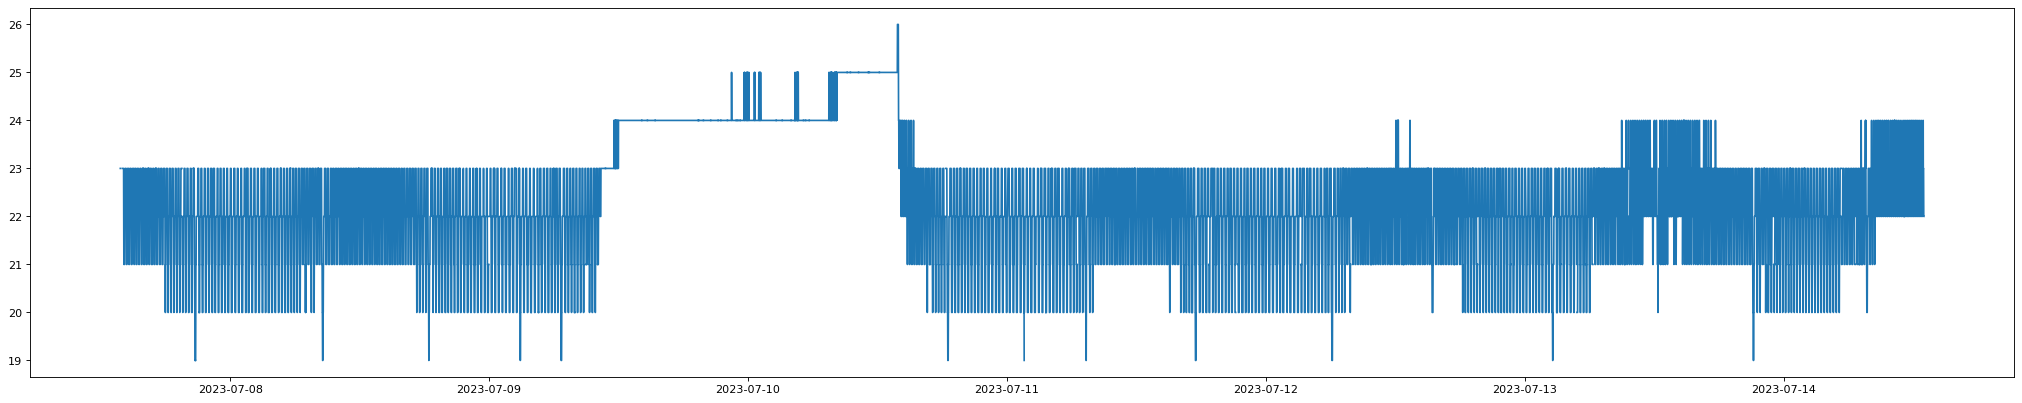

In [14]:
from matplotlib.pyplot import figure

figure(figsize=(32, 6), dpi=80)
#plt.xticks(rotation=90)
plt.plot(df["time"], df["temperature"])

In [15]:
temperature_df = df[['time', 'temperature']].copy()
temperature_df = temperature_df.rename(columns={'time': 'ds', 'temperature': 'y'})

In [16]:
temperature_df.head(10)

,ds,y
0,2023-07-07 13:48:40,NaN
1,2023-07-07 13:48:47,23.0
2,2023-07-07 13:49:13,NaN
3,2023-07-07 13:49:17,23.0
4,2023-07-07 13:49:48,23.0
5,2023-07-07 14:00:54,NaN
6,2023-07-07 14:00:57,23.0
7,2023-07-07 14:01:28,23.0
8,2023-07-07 14:01:58,23.0
9,2023-07-07 14:02:29,23.0


In [17]:
temperature_df.fillna(method="pad", inplace=True)

In [18]:
print(temperature_df.isna().sum())
temperature_df.dropna(inplace=True)

ds    0
y     1
dtype: int64


                   ds     y
0 2023-07-07 13:48:00  23.0
1 2023-07-07 13:49:00  23.0
2 2023-07-07 13:50:00   NaN
3 2023-07-07 13:51:00   NaN
4 2023-07-07 13:52:00   NaN
10030


<Axes: xlabel='ds'>

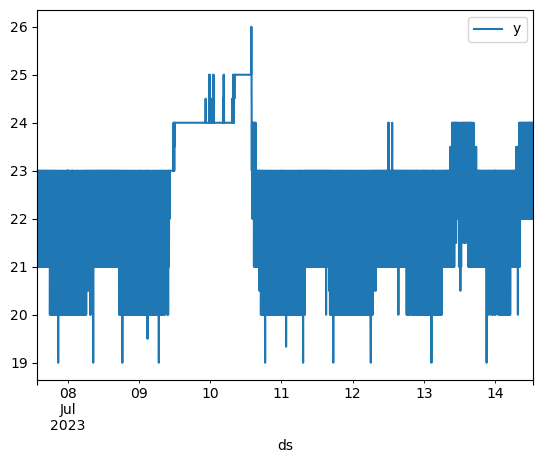

In [19]:
# Resample the DataFrame to 1-minute intervals and calculate the mean of each interval
downsampled_df = temperature_df.resample('T', on='ds').mean()


# Reset the index to the original index and keep the date in a separate column
downsampled_df.reset_index(inplace=True)

print(downsampled_df.head())
print(len(downsampled_df.index))
downsampled_df.plot(x='ds', y='y')

In [20]:
downsampled_df.isna().sum()

ds     0
y     21
dtype: int64

In [21]:
downsampled_df.fillna(method="pad", inplace=True)

In [22]:
downsampled_df.head(10)

,ds,y
0,2023-07-07 13:48:00,23.0
1,2023-07-07 13:49:00,23.0
2,2023-07-07 13:50:00,23.0
3,2023-07-07 13:51:00,23.0
4,2023-07-07 13:52:00,23.0
5,2023-07-07 13:53:00,23.0
6,2023-07-07 13:54:00,23.0
7,2023-07-07 13:55:00,23.0
8,2023-07-07 13:56:00,23.0
9,2023-07-07 13:57:00,23.0


In [23]:
temperature_df = downsampled_df.copy()

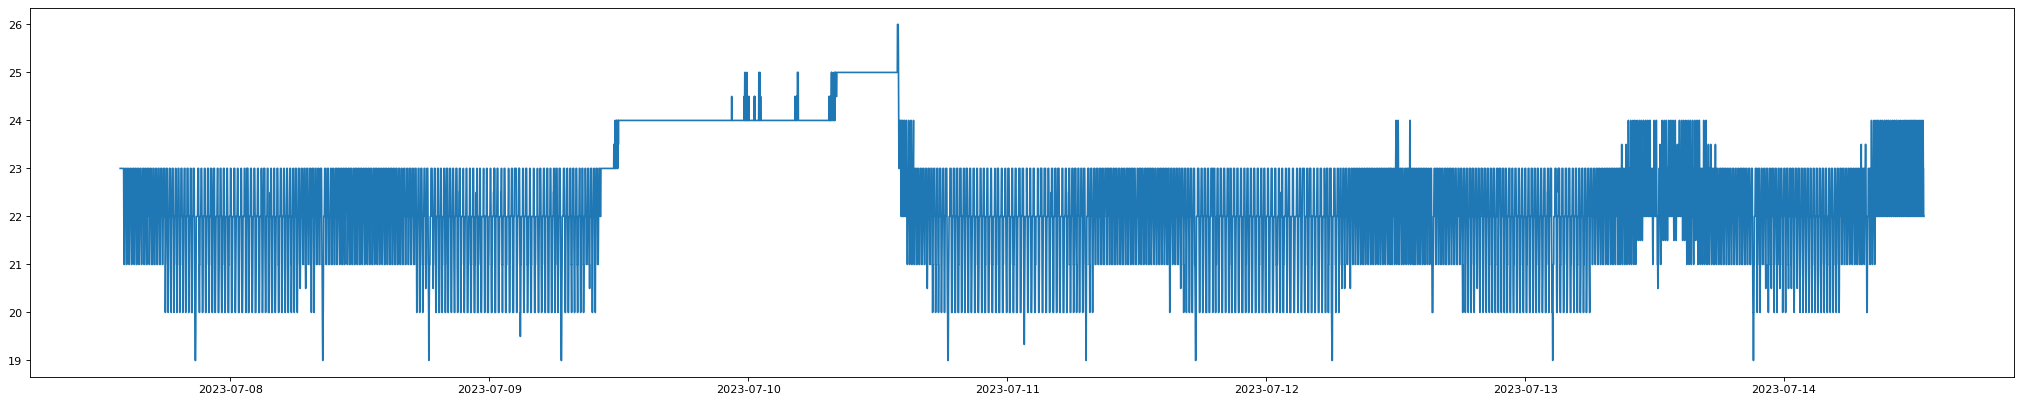

In [24]:
figure(figsize=(32, 6), dpi=80)
#plt.xticks(rotation=90)
plt.plot(temperature_df["ds"], temperature_df["y"])

10:44:43 - cmdstanpy - INFO - Chain [1] start processing
10:44:43 - cmdstanpy - INFO - Chain [1] done processing
10:44:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
10:44:43 - cmdstanpy - INFO - Chain [1] start processing
10:44:45 - cmdstanpy - INFO - Chain [1] done processing


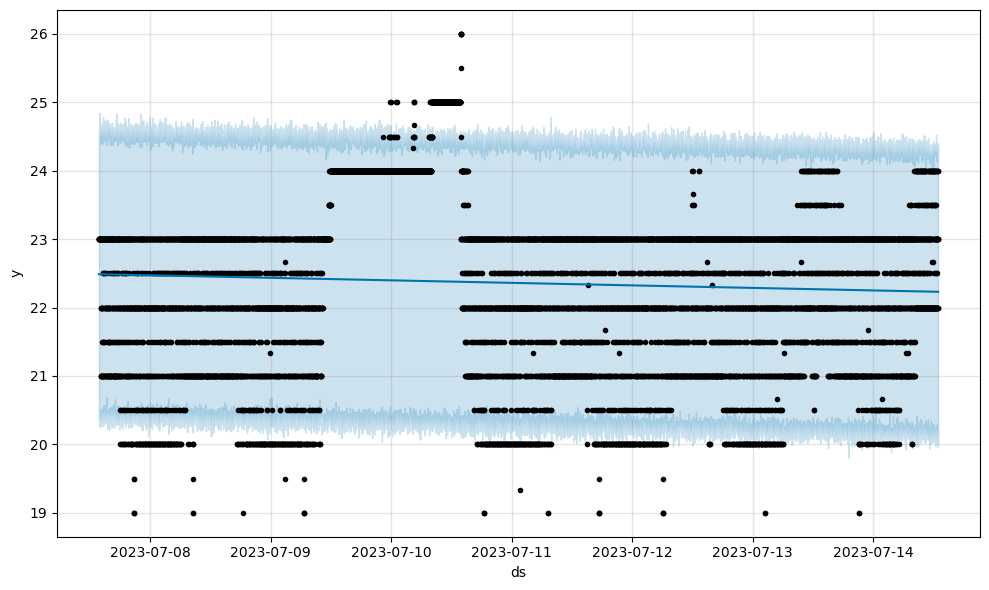

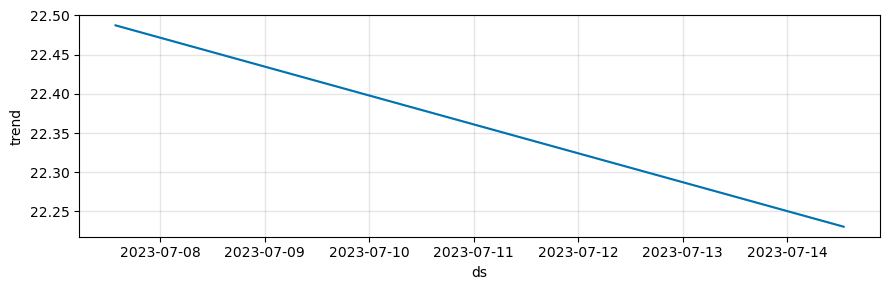

In [25]:
pred = fit_predict_model(temperature_df, show_plots=True, interval_width = 0.90)

In [26]:
anomalies_pred = detect_anomalies(pred)
#anomalies_pred.query('anomaly != 0') -1 are the anomalies under the area
anomalies_pred.query('anomaly == 1')

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
3472,2023-07-09 23:40:00,22.398545,22.398545,20.135362,24.404755,24.5,1,0.003888
3473,2023-07-09 23:41:00,22.398519,22.398519,20.493065,24.482184,25.0,1,0.020713
3485,2023-07-09 23:53:00,22.398212,22.398212,20.331713,24.393019,25.0,1,0.024279
3490,2023-07-09 23:58:00,22.398084,22.398084,20.419418,24.484779,24.5,1,0.000621
3529,2023-07-10 00:37:00,22.397085,22.397085,20.507246,24.442449,24.5,1,0.002349
...,...,...,...,...,...,...,...,...
4324,2023-07-10 13:52:00,22.376728,22.376728,20.310798,24.474724,26.0,1,0.058664
4325,2023-07-10 13:53:00,22.376702,22.376702,20.421418,24.536135,26.0,1,0.056302
4326,2023-07-10 13:54:00,22.376677,22.376677,20.270766,24.415858,26.0,1,0.060929
4327,2023-07-10 13:55:00,22.376651,22.376651,20.370724,24.396458,25.5,1,0.043276


/opt/conda/lib/python3.10/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


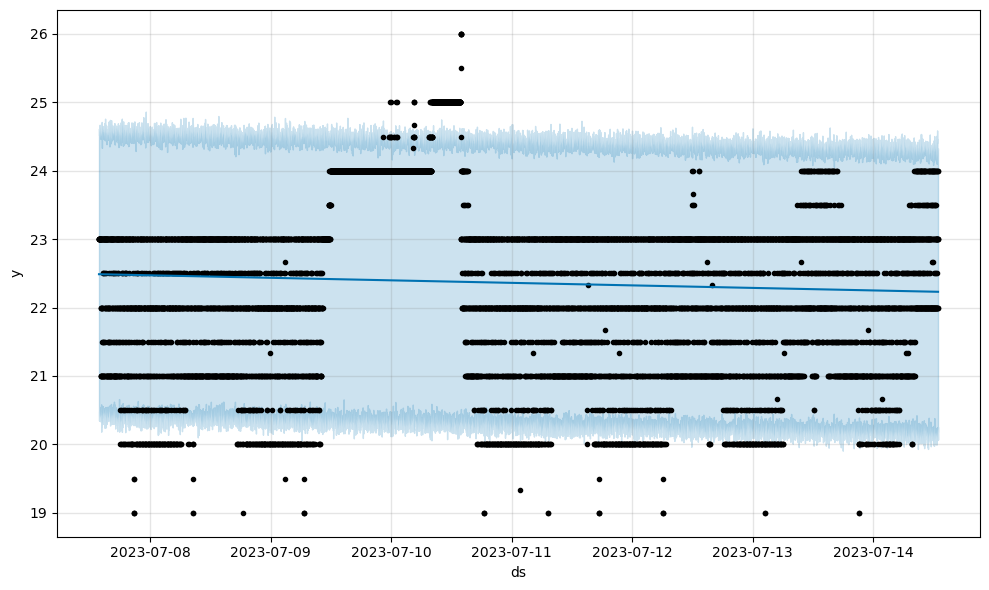

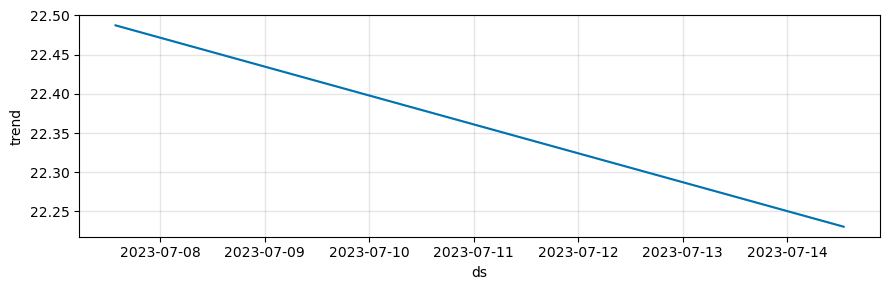

In [30]:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model
    
    forecast = m.predict(temperature_df)
    forecast['fact'] = temperature_df['y'].reset_index(drop = True)

    m.plot(forecast)
    m.plot_components(forecast)

In [35]:
forecast.query('yhat > 23')

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact


In [31]:
anomalies_pred = detect_anomalies(forecast)
#anomalies_pred.query('anomaly != 0') -1 are the anomalies under the area
anomalies_pred.query('anomaly == 1')

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
3470,2023-07-09 23:38:00,22.398596,22.398596,20.393587,24.369942,24.5,1,0.005309
3472,2023-07-09 23:40:00,22.398545,22.398545,20.261567,24.342116,24.5,1,0.006444
3473,2023-07-09 23:41:00,22.398519,22.398519,20.255260,24.417435,25.0,1,0.023303
3483,2023-07-09 23:51:00,22.398263,22.398263,20.121008,24.483357,24.5,1,0.000679
3485,2023-07-09 23:53:00,22.398212,22.398212,20.347984,24.431617,25.0,1,0.022735
...,...,...,...,...,...,...,...,...
4324,2023-07-10 13:52:00,22.376728,22.376728,20.328164,24.440440,26.0,1,0.059983
4325,2023-07-10 13:53:00,22.376702,22.376702,20.432248,24.554141,26.0,1,0.055610
4326,2023-07-10 13:54:00,22.376677,22.376677,20.516925,24.533370,26.0,1,0.056409
4327,2023-07-10 13:55:00,22.376651,22.376651,20.250138,24.442924,25.5,1,0.041454


In [24]:
plot_anomalies(anomalies_pred)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

See https://altair-viz.github.io/user_guide/large_datasets.html for information on how to plot large datasets, including how to install third-party data management tools and, in the right circumstance, disable the restriction

alt.LayerChart(...)

In [ ]:
##### The code below is for forecasting the anomaly

In [36]:
import numpy as np
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [37]:
# split an univariate sequence
def splitsequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


def plotMovingAverage(
    series,
    gt,
    window,
    title,
    plot_intervals=False,
    conf=95,
    plot_anomalies=True,
):
    cd = {99: 2.576, 98: 2.326, 95: 1.96, 90: 1.645}
    scale = cd[conf]
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(15, 5))
    plt.title(
        title
        + "\n window size= {}".format(window)
        + ", intrv= {}%".format(conf)
    )
    plt.plot(rolling_mean, "r", label="Rolling mean trend")
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bond, "r--")
        if plot_anomalies:
            anomalies = pd.DataFrame(index=gt.index, columns=gt.columns)
            anomalies[gt < lower_bond] = gt[gt < lower_bond]
            anomalies[gt > upper_bond] = gt[gt > upper_bond]
            plt.plot(anomalies, "ro", markersize=8, label="Anomaly")
    plt.plot(series[window:], label="Estimated values")
    plt.plot(gt[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [40]:
temperature_df.head(3)

,ds,y
0,2023-07-07 13:48:00,23.0
1,2023-07-07 13:49:00,23.0
2,2023-07-07 13:50:00,23.0


In [43]:
lim = int(np.round(0.60 * len(temperature_df.index)))
train = temperature_df["y"].head(lim)
test = temperature_df["y"][lim:]

temperaturecol = train.to_numpy()
temperaturerow = temperaturecol.tolist()
testcol = test.to_numpy()
testrow = testcol.tolist()

raw_seq = temperaturerow

n_steps = 3
out = 1

X, y = splitsequence(raw_seq, n_steps)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print("X shape is", X.shape)
print("y shape is", y.shape)

X shape is (6015, 3, 1)
y shape is (6015,)


In [48]:
model = Sequential()
model.add(
    Bidirectional(
        LSTM(100, activation="relu"), input_shape=(n_steps, n_features)
    )
)
model.add(Dense(out))
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=200, verbose="auto", use_multiprocessing=True)
model.save("lstmtemperature_raspberry_pi")

Epoch 1/200
188/188 [==============================] - 3s 5ms/step - loss: 24.9115
Epoch 2/200
188/188 [==============================] - 1s 6ms/step - loss: 0.6182
Epoch 3/200
188/188 [==============================] - 1s 6ms/step - loss: 0.4934
Epoch 4/200
188/188 [==============================] - 1s 5ms/step - loss: 0.4131
Epoch 5/200
188/188 [==============================] - 1s 5ms/step - loss: 0.3673
Epoch 6/200
188/188 [==============================] - 1s 5ms/step - loss: 0.3149
Epoch 7/200
188/188 [==============================] - 1s 5ms/step - loss: 0.2860
Epoch 8/200
188/188 [==============================] - 1s 5ms/step - loss: 0.2522
Epoch 9/200
188/188 [==============================] - 1s 5ms/step - loss: 0.2702
Epoch 10/200
188/188 [==============================] - 1s 5ms/step - loss: 0.2229
Epoch 11/200
188/188 [==============================] - 1s 5ms/step - loss: 0.2313
Epoch 12/200
188/188 [==============================] - 1s 6ms/step - loss: 0.2062
Epoch 13/200

In [50]:
Xx, Yy = splitsequence(testrow, n_steps)
x_input = Xx

x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], n_features))
print("x_input shape is", x_input.shape)
print("Yy shape is", Yy.shape)

yhat = model.predict(x_input, verbose=0)

x_input shape is (4009, 3, 1)
Yy shape is (4009,)


 MSE: 0.21912020926138587
 RMSE: 0.4681027763871796
 MAE: 0.3542068863961726
 MAPE: 0.016219931990381978
 R2: 0.7924909446779423
 std: 0.9544354677200317


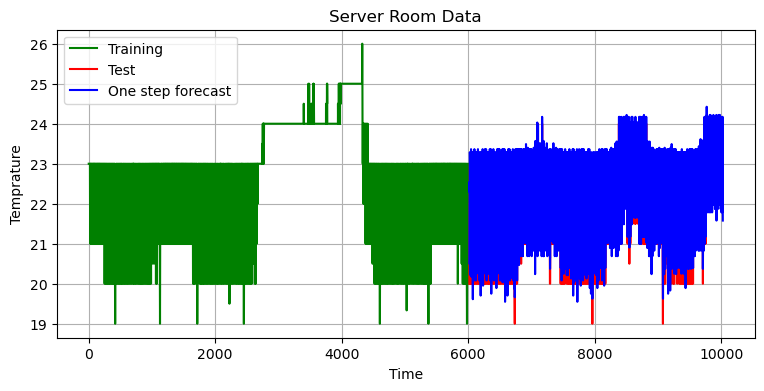

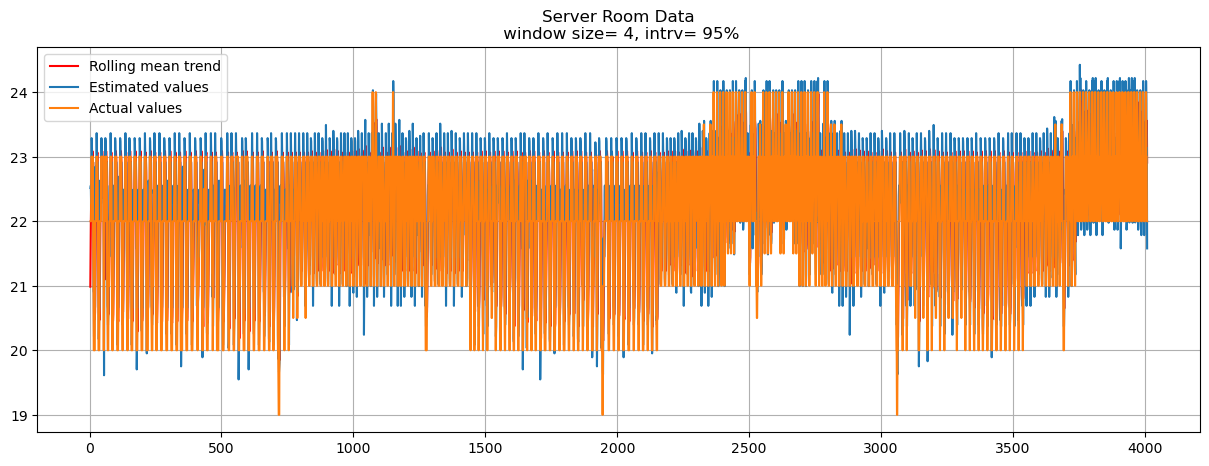

In [51]:
fig, ax = plt.subplots(figsize=(9, 4))
npre = 4
ax.set(title="Server Room Data", xlabel="Time", ylabel="Temprature")
ax.plot(temperaturerow, color="g", label="Training")
ax.plot([i + len(temperaturerow) for i in range(len(Yy))], Yy, color="r", label="Test")
ax.plot([i + len(temperaturerow) for i in range(len(yhat))], yhat, color="b", label="One step forecast")
plt.grid(True)
legend = ax.legend(loc="upper left")
legend.get_frame().set_facecolor("w")

MSE = mean_squared_error(Yy, yhat)
RMSE = np.sqrt(mean_squared_error(Yy, yhat))
mae = mean_absolute_error(Yy, yhat)
MAPE = mean_absolute_percentage_error(Yy, yhat)
R2 = r2_score(Yy, yhat)
std = np.std(yhat)
print(f" MSE: {MSE}\n RMSE: {RMSE}\n MAE: {mae}\n MAPE: {MAPE}\n R2: {R2}\n std: {std}")
plotMovingAverage(
    series=pd.DataFrame(yhat),
    gt=pd.DataFrame(Yy),
    window=4,
    title="Server Room Data",
    plot_intervals=False,
    conf=95,
    plot_anomalies=False,
)
plt.show()

In [49]:
values = [22, 22.5, 23]

model = load_model('lstmtemperature_raspberry_pi')
n_features = 1
online_values = np.array([values])
online_values = online_values.reshape((online_values.shape[0], online_values.shape[1], n_features))

yhat = model.predict(online_values, verbose=0)
print(yhat)

[[23.364618]]


In [52]:
!zip -r lstmtemperature_raspberry_pi_100_e_200_unscaled_mape_0_016.zip lstmtemperature_raspberry_pi

  adding: lstmtemperature_raspberry_pi/ (stored 0%)
  adding: lstmtemperature_raspberry_pi/assets/ (stored 0%)
  adding: lstmtemperature_raspberry_pi/keras_metadata.pb (deflated 89%)
  adding: lstmtemperature_raspberry_pi/saved_model.pb (deflated 90%)
  adding: lstmtemperature_raspberry_pi/variables/ (stored 0%)
  adding: lstmtemperature_raspberry_pi/variables/variables.index (deflated 61%)
  adding: lstmtemperature_raspberry_pi/variables/variables.data-00000-of-00001 (deflated 42%)
  adding: lstmtemperature_raspberry_pi/fingerprint.pb (stored 0%)


In [56]:
#!unzip lstmtemperature_raspberry_pi_100_e_200_unscaled_mape_0_016.zip

In [25]:
##### The code below was for the MeditCom 23 paper

In [26]:
import csv
humidity_lst = []
temprature_lst = []
time_lst = []
with open('input/tempreature/test_1.0.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        if row[3][:-1] == 'None' or row[5][:-1] == 'None':
            continue
        humidity_lst.append(float(row[3][:-1]))
        temprature_lst.append(float(row[5][:-1]))
        time_lst.append(row[9][:-1])

data = pd.DataFrame(
    {'timestamp': time_lst,
        'humidity': humidity_lst,
        'temperature': temprature_lst
    }
)
data["timestamp"] = pd.to_datetime(data["timestamp"], unit="s")

In [27]:
from datetime import datetime

t = pd.DataFrame()
t['ds'] = data['timestamp']
t['y'] = data['temperature']
#display(t)

In [28]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    display(t)

In [29]:
t.loc[454:483, 'y'] = 23

In [30]:
t.loc[331:389, 'y'] = 22

In [31]:
t.loc[258:303, 'y'] = 22

In [32]:
t.loc[106:250, 'y'] = 26

In [33]:
t.loc[0:16, 'y'] = [22, 22, 22, 22, 22, 22, 22, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

In [34]:
t['y'] = t['y'] - 1

In [35]:
from datetime import datetime, timedelta

datetime_sequence = [datetime.now() + timedelta(minutes=i) for i in range(555)]

In [36]:
t['ds'] = datetime_sequence
t['ds'] = pd.to_datetime(t['ds'], unit="s")

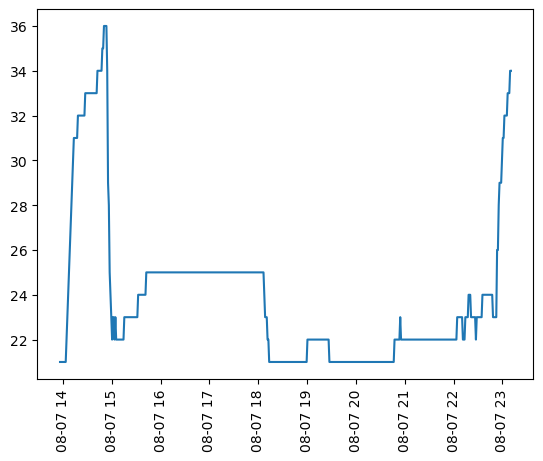

In [37]:
plt.xticks(rotation=90)
plt.plot(t['ds'], t['y'], )

In [38]:
t.head()

,ds,y
0,2023-08-07 13:56:31.382449,21.0
1,2023-08-07 13:57:31.382458,21.0
2,2023-08-07 13:58:31.382461,21.0
3,2023-08-07 13:59:31.382462,21.0
4,2023-08-07 14:00:31.382463,21.0


13:56:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send


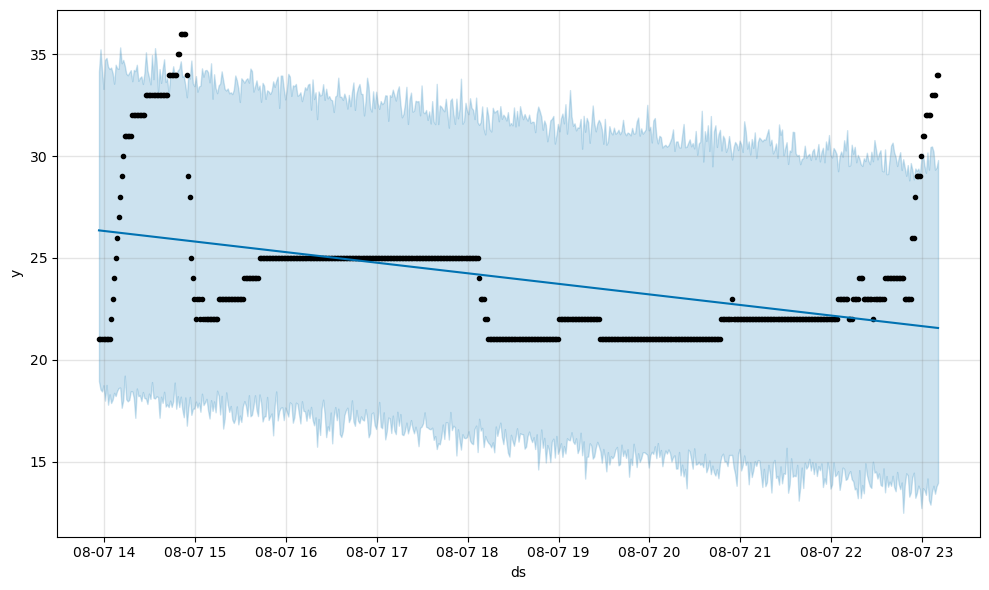

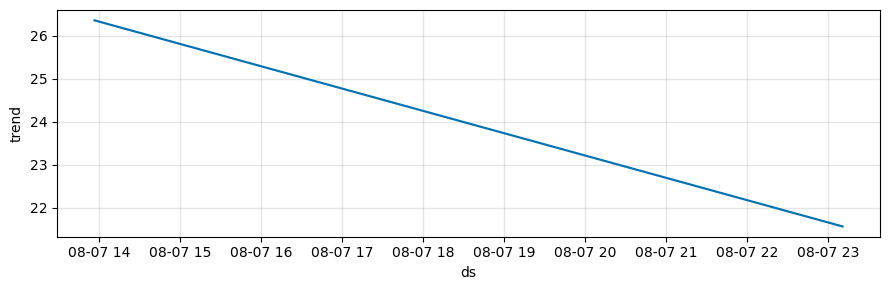

In [39]:
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
    
pred = fit_predict_model(t, show_plots=True, interval_width = 0.99)

In [40]:
anomalies_pred = detect_anomalies(pred)
#display(anomalies_pred)

In [41]:
plot_anomalies(anomalies_pred)

alt.LayerChart(...)